<a href="https://colab.research.google.com/github/johannpeterson/nijhawanlab/blob/master/amplicon_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook automates the analysis of high-throughput sequencing files from expermiments which submit a batch of combined samples for amplicon sequencing.

The following files are required:
1. Paired-read FASTQ files, e.g. `VK001_R1_001.fastq.gz` & `VK001_R2_001.fastq.gz`
1. Samples table, e.g. `VK001_samples.tsv`.  Discussed under **Samples Table**.
1. `primers.txt`.  This is a tab-delimited table of primers with 4 columns:
  1. `OriginalSeq` - the primer label
  1. `sequence` - the full sequence of the primer
  1. `barcode` - the primer "barcode"
  1. `direction` - the primer direction, either F or R

Current version as of 11 September 2022.  Duplicate for each analysis.

# Preliminaries

## Experiment-Specific Variables
The following cells should contain all the variables you need to change in order to run this analysis with different data files.  The variable `experiment` below is used to set the working directory and the file names for the fastq files and the table of samples.

In [ ]:
experiment = "JK001"
label_prefix = "oNB"

In [ ]:
base_directory = "/content/drive/My Drive/nijhawanlab/amplicons/"
data_directory = base_directory + "development/"
source_directory = base_directory + "source/"
R1_file = data_directory + experiment + "_R1_001.fastq.gz"
R2_file = data_directory + experiment + "_R2_001.fastq.gz"
primer_file = data_directory + "primers.txt"
samples_file = data_directory + experiment + "_samples.tsv"

In [ ]:
maximum_reads_per_file = 10**6

In [ ]:
minimum_read_quality = 20
minimum_barcode_length = 14
maximum_barcode_length = 30

In [ ]:
# TTCTTGACGAGTTCTTCTGA
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' 
# ACGCGTCTGGAACAATCAAC
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' 

reference_barcode_pattern = 'SWSWSWSWSWSWSWSWSWSW'
reference_barcode_regex_string = r"([GC][AT])+[GC]?"
primer_name_regex_string = r"(" + label_prefix + ")(\d{1,3})"
primer_name_regex_string

'(oNB)(\\d{1,3})'

## Mount the working directory & install modules:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Google Colab does not have BioPython installed:

In [ ]:
pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install ipdb
# import ipdb

In [ ]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
from itertools import cycle
from tqdm import tqdm
from io import StringIO
import locale

## Utility functions


In [ ]:
import sys
sys.path.insert(0, source_directory)

In [ ]:
%load_ext autoreload
%cd "$source_directory"
# I don't understand why you need to change the working directory if you have added it to the path.
%aimport jpbio.util
%cd "$data_directory"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/content/drive/My Drive/nijhawanlab/amplicons/source


# Read Input Files

## Read in primers.txt and store primers in various useful forms

In [ ]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(
        primers_IO, 
        delimiter='\t', 
        fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

primer_lookup

{'oNB177': {'len': 30,
  'sequence': 'GCTGGATTCAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB205': {'len': 30,
  'sequence': 'TAACTCAACAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB206': {'len': 30,
  'sequence': 'CGTGAGCCCAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB207': {'len': 30,
  'sequence': 'ATCAGAGGCAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB208': {'len': 30,
  'sequence': 'TATGGAGGCAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB209': {'len': 30,
  'sequence': 'GCGTTCAACAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB210': {'len': 30,
  'sequence': 'CGCAAGAACAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB211': {'len': 30,
  'sequence': 'CGACAGCCCAGCAACCAGGATTTATACAAG',
  'direction': 'F'},
 'oNB176': {'len': 28,
  'sequence': 'CGGTTCAACCCGTGATATTGCTGAAGAG',
  'direction': 'R'},
 'oNB194': {'len': 28,
  'sequence': 'TAACTCGGCCCGTGATATTGCTGAAGAG',
  'direction': 'R'},
 'oNB195': {'len': 28,
  'sequence': 'TAACAGTTCCCGTGATATTGCTGAAGAG',
  'direction': 

## Primer ID

The `IdPrimers` function finds the primers matching a sequence.  For each primer, it searches starting at the first position in the read sequence for the primer sequence, and starting at the last positiom for the reverse compliment of the primer sequence.  Becuase of the loop, it will return the last matching primer in each direction, and makes no attempt to deal with sequences matching multiple primers.

In [ ]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( jpbio.util.rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

## Sanity Checking

This cell defines a series of functions (named `sanity_...`), which operate on a `full_read` data structure as returned by the `analyzeReads` function.  Each `sanity_` function returns `True` or `False`, according as the read pair passes the particular quality check.  The `sanity_checks` structure is a list containing one dictionary for each `sanity_` function.  

In [ ]:
def sanity_id_match(full_read):
    return full_read['F_id'] == full_read['R_id']

def sanity_primer_match(full_read):
    return (
        (full_read['F_forward_primer'] == full_read['R_rc_primer']) &
        (full_read['F_rc_primer'] == full_read['R_forward_primer'])
    )

def sanity_all_primers_found(full_read):
    return (
        (full_read['F_forward_primer'] != None) & 
        (full_read['F_rc_primer'] != None) &
        (full_read['R_forward_primer'] != None) & 
        (full_read['R_rc_primer'] != None)
    )

def sanity_barcodes_match(full_read):
    return (full_read['F_barcode'] == full_read['R_barcode'])

def sanity_barcodes_length(full_read):
    lF = len(full_read['F_barcode'])
    lR = len(full_read['R_barcode'])
    return (
        (lF <= maximum_barcode_length) &
        (lF >= minimum_barcode_length) &
        (lR <= maximum_barcode_length) &
        (lR >= minimum_barcode_length)
    )

sanity_barcode_regex = re.compile(reference_barcode_regex_string)
def sanity_barcode_pattern(full_read):
    if sanity_barcode_regex.fullmatch(full_read['R_barcode']):
        return True
    else:
        return False
    
def sanity_barcodes_quality(full_read):
    return (
        (min(full_read['F_quality']) >= minimum_read_quality) &
        (min(full_read['R_quality']) >= minimum_read_quality)
    )

sanity_checks = [
    {
        'id':'any',
        'label':'Any Check',
        'description':'Read pairs failing any sanity check.',
        'function':(lambda _: True)
    },
    {
        'id':'id_match',
        'label':'IDs Match',
        'description':'R1 & R2 read IDs match.',
        'function':sanity_id_match},
    {
        'id':'primer_match',
        'label':'Primers Match',
        'description':'Forward & reverse primers for R1 & R2 match.',
        'function':sanity_primer_match
    },
    {
        'id':'primers_found',
        'label':'Primers Found',
        'description':'Forward & reverse primers identified in both reads.',
        'function':sanity_all_primers_found
    },
    {
        'id':'barcodes_match',
        'label':'Barcodes Match',
        'description':'Barcodes from R1 & R2 reads match exactly.',
        'function':sanity_barcodes_match
    },
    {
        'id':'barcode_length',
        'label':'Barcode Length',
        'description':'Barcode lengths are within the required range.',
        'function':sanity_barcodes_length
    },
    {
        'id':'barcode_pattern',
        'label':'Barcode Pattern',
        'description':'The R1 barcode matches the specified pattern (SWSW...).',
        'function':sanity_barcode_pattern
    },
    {
        'id':'barcodes_quality',
        'label':'Barcode Read Quality',
        'description':'The minimum read quality (PHRED score) for both barcodes is at least the minumum specified.',
        'function':sanity_barcodes_quality
    }
]

## Analyze Read
Identify the direction of the reads, forward & reverse primers, barcode location & sequence.  The `analyzeReads` function returns a dictionary structure with elements for the read IDs, forward and reverse compliment primers for each read, locations in the reads for the barcodes, the barcode sequences and the sequences of quality scores corresponding to the barcodes.

In [ ]:
def analyzeReads(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = F_primers['rc_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = R_primers['rc_primer']

    r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
    r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
    r['R_pre_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) ) 
    r['R_post_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) ) 
    r['F_barcode_loc'] = [r['F_pre_loc']+len(reference_sequence_pre), r['F_post_loc']]
    r['R_barcode_loc'] = [r['R_post_loc']+len(reference_sequence_post), r['R_pre_loc']]
    r['F_barcode'] = str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]]
    r['R_barcode'] = jpbio.util.rcDNA( str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ] )
    
    r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]
    
    return r



This function (`analyzeReadsAndFillInPrimers`) is a modified version of the function above, to allow for pairs of reads that do not overlap enough to have both primers on each read in the pair.  It could use some fixing up, as it currently makes assumptions about the direction of the reads which work for the JK001 experiment but may not be valid in general.

In [ ]:
def analyzeReadsAndFillInPrimers(F_read, R_read, F_primers, R_primers):
    r = {}
    r['F_id'] = F_read.id
    r['R_id'] = R_read.id
    r['F_forward_primer'] = F_primers['fwd_primer']
    r['F_rc_primer'] = R_primers['fwd_primer']
    r['R_forward_primer'] = R_primers['fwd_primer']
    r['R_rc_primer'] = F_primers['fwd_primer']

    # r['F_pre_loc'] = F_read.seq.find(reference_sequence_pre)
    # r['F_post_loc'] = F_read.seq.find(reference_sequence_post)
    # r['R_pre_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) ) 
    # r['R_post_loc'] = R_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) ) 
    r['F_pre_loc'] = F_read.seq.find( jpbio.util.rcDNA(reference_sequence_pre) )
    r['F_post_loc'] = F_read.seq.find( jpbio.util.rcDNA(reference_sequence_post) )
    r['R_pre_loc'] = R_read.seq.find(reference_sequence_pre) 
    r['R_post_loc'] = R_read.seq.find(reference_sequence_post)
    r['F_barcode_loc'] = [r['F_post_loc']+len(reference_sequence_post), r['F_pre_loc']]
    r['R_barcode_loc'] = [r['R_pre_loc']+len(reference_sequence_pre), r['R_post_loc']]
    r['F_barcode'] = jpbio.util.rcDNA( str(F_read.seq)[ r['F_barcode_loc'][0] : r['F_barcode_loc'][1]] )
    r['R_barcode'] = str(R_read.seq)[ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]

    # print(r['F_barcode'])
    # print(r['R_barcode'])

    # print(F_read.seq)
    # print(R_read.seq)
    
    r['F_quality'] = F_read.letter_annotations["phred_quality"][ r['F_barcode_loc'][0] : r['F_barcode_loc'][1] ]
    r['R_quality'] = R_read.letter_annotations["phred_quality"][ r['R_barcode_loc'][0] : r['R_barcode_loc'][1] ]
    
    return r

## Figure out how many sequences are in each file

This runs separate processes to decompress and count lines in the input fastq files.  If it takes too much time, it can be skipped, but it doesn't take very long compared with processing the files below.  The advantage of running it is that the progress bar during processing accurately reflects how many sequences there are.

If [`maximum_reads_per_file`](#scrollTo=EhIRApjv_PzZ) is set to a smaller number than the number of reads in the FASTQ files, then only read that many pairs.

In [ ]:
R1_lines = !cat "$R1_file" | gunzip | wc -l
R2_lines = !cat "$R2_file" | gunzip | wc -l

In [ ]:
import math
maximum_reads_per_file = min(
    maximum_reads_per_file,
    int(math.ceil( max( int(R1_lines[0])/4, int(R2_lines[0])/4) ))
)

424725

## Load paired reads from FASTQ files
This is the code that loops through the paired read FASTQ files.  It is the most time-consuming part of the process.  (It runs at about 1500 sequence pairs per second, so about 11 minutes to process 1 million paired reads.)

In [ ]:
with gzip.open(R1_file, "rt") as R1, gzip.open(R2_file, "rt") as R2:
  reads1 = SeqIO.parse(R1, "fastq")
  reads2 = SeqIO.parse(R2, "fastq")
  maxReads = maximum_reads_per_file
  readNumber = 1
  reads_list = []
  quality_statistics = {
    "R1": {
      "read_counts":[], 
      "N_counts":[],
      "phred_scores":[],
      "read_lengths":[]
      }, 
    "R2": {
      "read_counts":[], 
      "N_counts":[],
      "phred_scores":[],
      "read_lengths":[]
      }
    }
  sanity_failures = {i['id']:0 for i in sanity_checks}
        
  progress_bar = tqdm(total=maxReads)
  for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)

    # identify the primers and analyze the read pair
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    if R1_primers['fwd_direction'] == 'F':
      full_read = analyzeReadsAndFillInPrimers(read1, read2, R1_primers, R2_primers)
    else:
      full_read = analyzeReadsAndFillInPrimers(read2, read1, R2_primers, R1_primers)

    # quality checks on the read pair
    any_failure = False
    for check in sanity_checks:
      try:
          test_passes = check['function'](full_read)
      except ValueError:
          test_passes = False
      if not test_passes:
          sanity_failures[check['id']] += 1
          any_failure = True
    if any_failure:
      sanity_failures['any'] += 1
    else:
      reads_list.append(
          {'barcode':full_read['F_barcode'],
            'forward_primer':full_read['F_forward_primer'],
            'reverse_primer':full_read['F_rc_primer']
          }
      )

    # tabulate quality statistics
    R1_quality = read1.letter_annotations["phred_quality"]
    R2_quality = read2.letter_annotations["phred_quality"]
    R1_length = len(R1_sequence)
    R2_length = len(R2_sequence)
    quality_statistics["R1"]["read_counts"] = jpbio.util.pad_list(quality_statistics["R1"]["read_counts"], R1_length, 0)
    quality_statistics["R2"]["read_counts"] = jpbio.util.pad_list(quality_statistics["R2"]["read_counts"], R2_length, 0)
    quality_statistics["R1"]["N_counts"] = jpbio.util.pad_list(quality_statistics["R1"]["N_counts"], R1_length, 0)
    quality_statistics["R2"]["N_counts"] = jpbio.util.pad_list(quality_statistics["R2"]["N_counts"], R2_length, 0)
    quality_statistics["R1"]["phred_scores"] = jpbio.util.pad_dict_list(quality_statistics["R1"]["phred_scores"], R1_length)
    quality_statistics["R2"]["phred_scores"] = jpbio.util.pad_dict_list(quality_statistics["R2"]["phred_scores"], R2_length)
    quality_statistics["R1"]["read_lengths"].append(R1_length)
    quality_statistics["R2"]["read_lengths"].append(R2_length)

    for i in range(R1_length):
      quality_statistics["R1"]["read_counts"][i] += 1
      if R1_sequence[i] == 'N':
          quality_statistics["R1"]["N_counts"][i] += 1
      q = R1_quality[i]
      if q in quality_statistics["R1"]["phred_scores"][i]:
          quality_statistics["R1"]["phred_scores"][i][ q ] += 1
      else:
          quality_statistics["R1"]["phred_scores"][i][ q ] = 1
                
    for i in range(R2_length):
      quality_statistics["R2"]["read_counts"][i] += 1
      if R2_sequence[i] == 'N':
          quality_statistics["R2"]["N_counts"][i] += 1
      q = R2_quality[i]
      if q in quality_statistics["R2"]["phred_scores"][i]:
          quality_statistics["R2"]["phred_scores"][i][ q ] += 1
      else:
          quality_statistics["R2"]["phred_scores"][i][ q ] = 1

    progress_bar.update(1)
    if readNumber == maxReads:
      break
    readNumber += 1

progress_bar.close()

#for i in sanity_failures:
#    sanity_failures[i['id']]['label'] = sanity_checks[i['id']]
            
# print("maxReads: {}\nTotal reads: {}".format(maxReads,readNumber))
# reads_table = pd.DataFrame(reads_list)

100%|██████████| 424725/424725 [04:54<00:00, 1440.90it/s]

maxReads: 424725
Total reads: 424725


`reads_list` is now a list of dictionaries, one for each read pair which passed the sanity checks.

In [ ]:
reads_list[0:5]

[{'barcode': 'GTGACTGTGTGACTCAGTCTCTCA',
  'forward_primer': 'oNB206',
  'reverse_primer': 'oNB202'},
 {'barcode': 'GACTCAGTGTGTCTGTCAGTCAGT',
  'forward_primer': 'oNB205',
  'reverse_primer': 'oNB194'},
 {'barcode': 'GTGAGTGTGTGTGAGTCTGACACT',
  'forward_primer': 'oNB206',
  'reverse_primer': 'oNB176'},
 {'barcode': 'CTCACTGAGTGACACACACAGAGA',
  'forward_primer': 'oNB206',
  'reverse_primer': 'oNB198'},
 {'barcode': 'GTCTCACACTGTGTCTCTGTGACT',
  'forward_primer': 'oNB177',
  'reverse_primer': 'oNB194'}]

In [ ]:
barcodes = pd.DataFrame(
    reads_list
)

In [ ]:
barcodes

,barcode,forward_primer,reverse_primer
0,GTGACTGTGTGACTCAGTCTCTCA,oNB206,oNB202
1,GACTCAGTGTGTCTGTCAGTCAGT,oNB205,oNB194
2,GTGAGTGTGTGTGAGTCTGACACT,oNB206,oNB176
3,CTCACTGAGTGACACACACAGAGA,oNB206,oNB198
4,GTCTCACACTGTGTCTCTGTGACT,oNB177,oNB194
...,...,...,...
185067,GTGAGTGTGTGTGAGTCTGACACT,oNB206,oNB176
185068,GTGAGTGTGAGACTGTCAGAGAGA,oNB205,oNB176
185069,CTCTCAGAGTGACTCTCTGAGTCA,oNB177,oNB197
185070,GTCTGTGACTCTCTGAGTGTCTCA,oNB177,oNB176


# Quality Checking

## Barcode Length

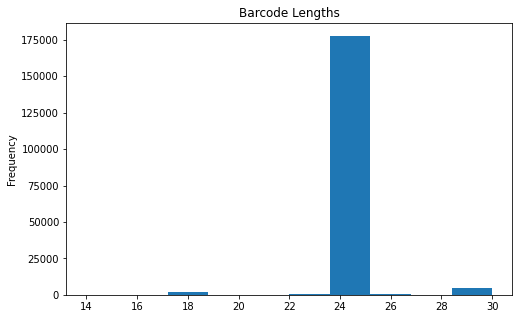

In [ ]:
fig_barcode_lengths, axs_barcode_lengths = plt.subplots( figsize=(8,5) )
barcodes['barcode'].apply(len).plot.hist(title='Barcode Lengths', ax=axs_barcode_lengths)

In [ ]:
jpbio.util.export_figure(fig_barcode_lengths, "barcode_lengths", data_directory, experiment)

## Examine the read pairs failing sanity checks

In [ ]:
sanity_checks_lookup = {i["id"]:i["label"] for i in sanity_checks} 
checks_data_frame = pd.DataFrame(
    [[i, sanity_failures[i], sanity_checks_lookup[i]] for i in sanity_failures],
    columns = ['id', 'count', 'label']
).sort_values('count', ascending=False)

In [ ]:
checks_data_frame

,id,count,label
0,any,239653,Any Check
7,barcodes_quality,189931,Barcode Read Quality
6,barcode_pattern,100003,Barcode Pattern
3,primers_found,92547,Primers Found
4,barcodes_match,92537,Barcodes Match
5,barcode_length,87605,Barcode Length
1,id_match,0,IDs Match
2,primer_match,0,Primers Match


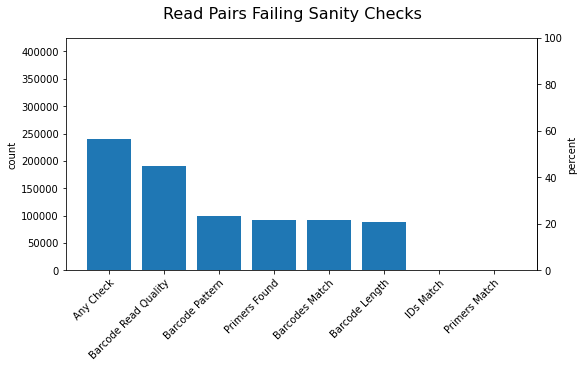

In [ ]:
fig_sanity, ax_sanity = plt.subplots(constrained_layout=True, figsize=(8,5))
fig_sanity.suptitle('Read Pairs Failing Sanity Checks', fontsize=16)

ax_sanity.bar(data=checks_data_frame, height='count', x='label')

def n_to_percent(n):
    return 100*n/readNumber

def percent_to_n(p):
    return p*readNumber/100

secax = ax_sanity.secondary_yaxis('right', functions=(n_to_percent, percent_to_n))
secax.set_ylabel('percent')
ax_sanity.set_ylabel('count')
ax_sanity.set_ylim([0, readNumber])
plt.setp(ax_sanity.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [ ]:
jpbio.util.export_figure(fig_sanity, "sanity_checks", data_directory, experiment)

## Examine the Overall Read Quality

In [ ]:
def SeqDiagnosticPlot(quality_statistics, maintitle="Read Quality"):

    def mean_from_dictionary_of_counts(d):
        M = 0
        T = 0
        for k in d:
            M += k*d[k]
            T += d[k]
        return M/T
    
    max_length = len(quality_statistics["read_counts"])
    positions = range(1, max_length + 1)
    max_qual_by_position = [max( [k for k in d] ) for d in quality_statistics["phred_scores"]]
    min_qual_by_position = [min( [k for k in d] ) for d in quality_statistics["phred_scores"]]
    mean_qual_by_position = [mean_from_dictionary_of_counts(d) for d in quality_statistics["phred_scores"]]
    max_N_count = max([10, max( quality_statistics["N_counts"] )])
    
    fig, (axis_quality, axis_N, axis_read_count) = plt.subplots(
        3,1,
        sharex='all',
        figsize=(15,7)
    )
    fig.suptitle(maintitle, fontsize=16)
    
    min_max_handle = axis_quality.fill_between(
        x=positions, 
        y1=min_qual_by_position, 
        y2=max_qual_by_position, 
        color="lightgrey", 
        label='range')
    mean_handle, = axis_quality.step(
        x=positions,
        y=mean_qual_by_position, 
        label='mean')
    axis_quality.legend(loc='lower center')
    axis_quality.set_xlabel('position')
    axis_quality.set_ylabel('quality')
    axis_quality.yaxis.grid(True)
    axis_quality.spines["bottom"].set_visible(True)
    axis_quality.spines["top"].set_visible(False)
    axis_quality.spines["left"].set_visible(True)
    axis_quality.spines["right"].set_visible(False)
    
    axis_read_count.set_yscale('log')
    axis_read_count.plot(quality_statistics["read_counts"], color='grey')
    axis_read_count.hist(quality_statistics["read_lengths"], range=(0,max_length), bins=25, color='lightblue')
    axis_read_count.set_ylabel('read count')
    axis_read_count.spines["bottom"].set_visible(True)
    axis_read_count.spines["top"].set_visible(False)
    axis_read_count.spines["left"].set_visible(True)
    axis_read_count.spines["right"].set_visible(False)
    
    axis_N.spines["bottom"].set_visible(True)
    axis_N.spines["top"].set_visible(False)
    axis_N.spines["left"].set_visible(True)
    axis_N.spines["right"].set_visible(False)
    axis_N.set_ylim([0, max_N_count])
    axis_N.step(x=positions, y=quality_statistics["N_counts"])
    axis_N.set_ylabel('N content')

    return fig

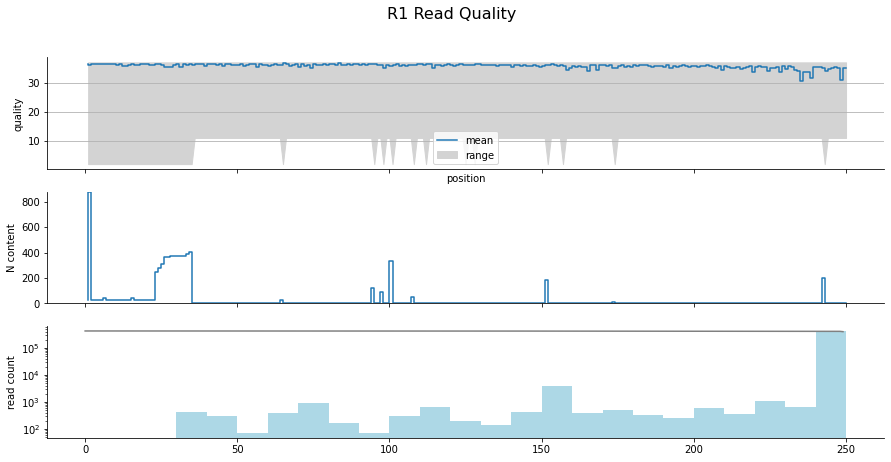

In [ ]:
fig_R1 = SeqDiagnosticPlot(quality_statistics["R1"], maintitle="R1 Read Quality")

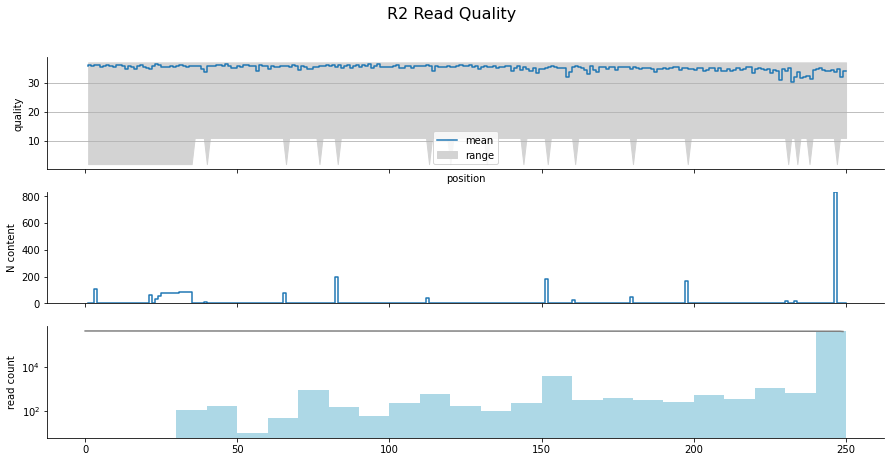

In [ ]:
fig_R2 = SeqDiagnosticPlot(quality_statistics["R2"], maintitle="R2 Read Quality")

In [ ]:
jpbio.util.export_figure(fig_R1, "R1_quality", data_directory, experiment)
jpbio.util.export_figure(fig_R2, "R2_quality", data_directory, experiment)

# Samples Table

<a id='s1'></a>
The `samples.tsv` file should be a tab-separated table of the sample IDs, with row & column labels indicating the primers for that sample.  

Like this:

| | | | | | | | | | | | | | | |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|	| oNB176 | oNB194 | oNB195 | oNB196 | oNB197 | oNB198 | oNB199 | oNB200 | oNB201 | oNB202 | oNB203 | oNB204 |
oNB177 | 2281 | 2282 | 2283 | 2285 | 2286 | 2287 | 2293 | 2294 | 2301 | 2302 | 2306 | 2307 |
oNB205 | 2308 | 2315 | 2316 | 2317 | 2318 | 2331 | 2332 | 2333 | 2334 | 2351 | 2352 | 2353 |
oNB206 | 2354 | 2355 | 2356 | 2357 | 2358 | 2359 | 2360 | 2394 | 2398 | water | Hct116 | c9 |
oNB207 | | | | | | | | | | | | | | | |											
oNB208 | | | | | | | | | | | | | | | |							
oNB209 | | | | | | | | | | | | | | | |
oNB210 | | | | | | | | | | | | | | | |
oNB211 | | | | | | | | | | | | | | | |


In [ ]:
with open(samples_file, 'r') as f:
    samples_table = f.read()
    print(samples_table)

	oNB176	oNB194	oNB195	oNB196	oNB197	oNB198	oNB199	oNB200	oNB201	oNB202	oNB203	oNB204
oNB177	2281	2282	2283	2285	2286	2287	2293	2294	2301	2302	2306	2307
oNB205	2308	2315	2316	2317	2318	2331	2332	2333	2334	2351	2352	2353
oNB206	2354	2355	2356	2357	2358	2359	2360	2394	2398	water	Hct116	c9
oNB207												
oNB208												
oNB209												
oNB210												
oNB211												



In [ ]:
primer_name_regex = re.compile(primer_name_regex_string)

def pad_primer(s):
    m = primer_name_regex.match(s)
    if m is not None:
      return m.group(1) + m.group(2).rjust(3, '0')
    else:
      return None

with open(samples_file, "r") as f:
    csvraw = list(csv.reader(f, delimiter='\t'))
col_headers = [pad_primer(h) for h in csvraw[0][1:] ]
row_headers = [ pad_primer(row[0]) for row in csvraw[1:] ]
data = [row[1:] for row in csvraw[1:]]
sample_list = [s for sublist in data for s in sublist if s != '']
sample_dict = {row_headers[r]:{col_headers[c]:data[r][c] for c in range(len(col_headers))} for r in range(0, len(row_headers))}

In [ ]:
sample_dict

{'oNB177': {'oNB176': '2281',
  'oNB194': '2282',
  'oNB195': '2283',
  'oNB196': '2285',
  'oNB197': '2286',
  'oNB198': '2287',
  'oNB199': '2293',
  'oNB200': '2294',
  'oNB201': '2301',
  'oNB202': '2302',
  'oNB203': '2306',
  'oNB204': '2307'},
 'oNB205': {'oNB176': '2308',
  'oNB194': '2315',
  'oNB195': '2316',
  'oNB196': '2317',
  'oNB197': '2318',
  'oNB198': '2331',
  'oNB199': '2332',
  'oNB200': '2333',
  'oNB201': '2334',
  'oNB202': '2351',
  'oNB203': '2352',
  'oNB204': '2353'},
 'oNB206': {'oNB176': '2354',
  'oNB194': '2355',
  'oNB195': '2356',
  'oNB196': '2357',
  'oNB197': '2358',
  'oNB198': '2359',
  'oNB199': '2360',
  'oNB200': '2394',
  'oNB201': '2398',
  'oNB202': 'water',
  'oNB203': 'Hct116',
  'oNB204': 'c9'},
 'oNB207': {'oNB176': '',
  'oNB194': '',
  'oNB195': '',
  'oNB196': '',
  'oNB197': '',
  'oNB198': '',
  'oNB199': '',
  'oNB200': '',
  'oNB201': '',
  'oNB202': '',
  'oNB203': '',
  'oNB204': ''},
 'oNB208': {'oNB176': '',
  'oNB194': '',
 

In [ ]:
barcodes['sample'] = barcodes.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [ ]:
barcodes

,barcode,forward_primer,reverse_primer,sample
0,GTGACTGTGTGACTCAGTCTCTCA,oNB206,oNB202,water
1,GACTCAGTGTGTCTGTCAGTCAGT,oNB205,oNB194,2315
2,GTGAGTGTGTGTGAGTCTGACACT,oNB206,oNB176,2354
3,CTCACTGAGTGACACACACAGAGA,oNB206,oNB198,2359
4,GTCTCACACTGTGTCTCTGTGACT,oNB177,oNB194,2282
...,...,...,...,...
185067,GTGAGTGTGTGTGAGTCTGACACT,oNB206,oNB176,2354
185068,GTGAGTGTGAGACTGTCAGAGAGA,oNB205,oNB176,2308
185069,CTCTCAGAGTGACTCTCTGAGTCA,oNB177,oNB197,2286
185070,GTCTGTGACTCTCTGAGTGTCTCA,oNB177,oNB176,2281


## Read Count per Sample

In [ ]:
counts_by_sample = barcodes.groupby(by='sample').size().reset_index(name='count').sort_values(['count'], ascending=[False])

In [ ]:
counts_by_sample

,sample,count
27,2357,15364
15,2317,12244
29,2359,10625
17,2331,8091
25,2355,8088
3,2285,8029
21,2351,8018
23,2353,7623
24,2354,7550
26,2356,6690


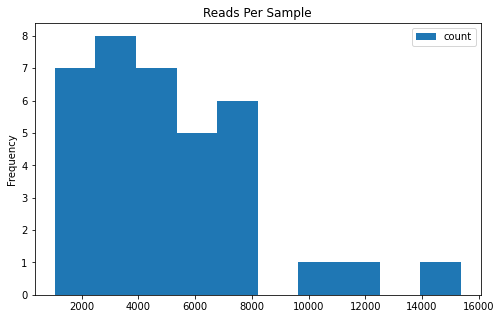

In [ ]:
fig_counts_by_sample, axs_counts_by_sample = plt.subplots( figsize=(8,5) )
counts_by_sample.plot.hist(title='Reads Per Sample', ax=axs_counts_by_sample)

In [ ]:
jpbio.util.export_figure(fig_counts_by_sample, "counts_by_sample", data_directory, experiment)

# Analysis By Sample

## Top 10 Reads per Sample

In [ ]:
counts_table = barcodes.groupby(by=["forward_primer","reverse_primer","sample","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","sample","barcode","count"]
counts_table

,forward_primer,reverse_primer,sample,barcode,count
253,oNB177,oNB176,2281,GTGAGTGTGTGTGAGTCTGACACT,358
167,oNB177,oNB176,2281,GAGTGTGTGTGACAGTGTGACTCA,275
292,oNB177,oNB176,2281,GTGTGTGTGTGACACTGTGTCTCT,244
233,oNB177,oNB176,2281,GTGACTGTGTGACTCAGTCTCTCA,155
160,oNB177,oNB176,2281,GAGTGTGACAGTCTGTGTGACTGT,116
...,...,...,...,...,...
11182,oNB206,oNB204,c9,GTGTGTGTGTGAGTCTGAGAGTGA,1
11183,oNB206,oNB204,c9,GTGTGTGTGTGTCAGTCAGACAGA,1
11184,oNB206,oNB204,c9,GTGTGTGTGTGTCAGTGTGACTCT,1
11186,oNB206,oNB204,c9,GTGTGTGTGTGTGTGTGTGACAGT,1


In [ ]:
len( counts_table['barcode'].unique() )

3154

In [ ]:
top_10_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()

In [ ]:
top_10_counts_table

,forward_primer,reverse_primer,sample,barcode,count
0,oNB177,oNB176,2281,GTGAGTGTGTGTGAGTCTGACACT,358
1,oNB177,oNB176,2281,GAGTGTGTGTGACAGTGTGACTCA,275
2,oNB177,oNB176,2281,GTGTGTGTGTGACACTGTGTCTCT,244
3,oNB177,oNB176,2281,GTGACTGTGTGACTCAGTCTCTCA,155
4,oNB177,oNB176,2281,GAGTGTGACAGTCTGTGTGACTGT,116
...,...,...,...,...,...
355,oNB206,oNB204,c9,GTGACAGAGTGTCACAGTGACTGT,212
356,oNB206,oNB204,c9,GAGTCTCACAGACACTCTGACTGA,197
357,oNB206,oNB204,c9,GTGTGTCTGTGAGTGACAGTGACT,183
358,oNB206,oNB204,c9,CTCTGAGACTCTCTCTCACTCAGA,166


In [ ]:
top_10_counts_table.to_excel(
    experiment + "_top_10_reads.xlsx",
    sheet_name = "Top 10 Reads"
)

## Water Control

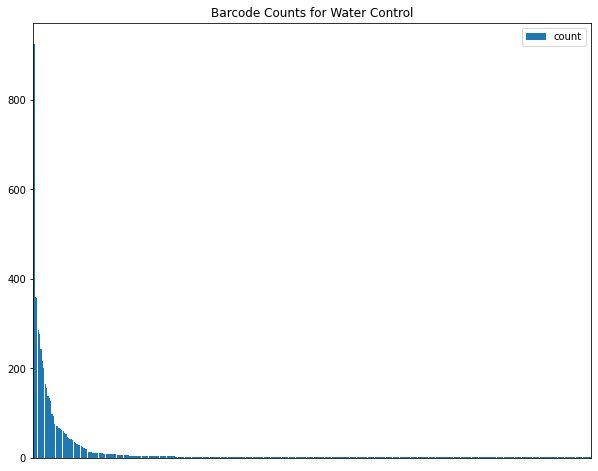

In [ ]:
fig_water_counts, axs_water_counts = plt.subplots( figsize=(8,5) )

counts_table[counts_table['sample']=='water'].sort_values(
    "count", 
    ascending=False
).plot.bar(
    y="count", 
    xticks=[], 
    figsize=(10,8),
    title='Barcode Counts for Water Control',
    ax=axs_water_counts,
    width=0.9
)

`water_count` is the maximum number of reads for a single barcode found in the water control sample.

In [ ]:
water_count = max(counts_table[ counts_table['sample'] == 'water' ]['count'])
water_count

926

Filter the table of barcode counts by excluding all barcodes with a count less than the maximum count in the water control.

## Analyze Barcode Distribution by Sample

### Interactive Histogram by Sample ID

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
samples_list = list( counts_table['sample'].unique() )

In [ ]:
@interact
def counts_for_sample(sample=samples_list):
    return counts_table[ counts_table['sample'] == sample ] \
        .head(10) \
        .reset_index(drop=True) \
        .style.bar(subset=['count'],color='lightblue') \
        .hide_index() \
        .hide_columns(['sample','forward_primer','reverse_primer'])

interactive(children=(Dropdown(description='sample', options=('2281', '2282', '2283', '2285', '2286', '2287', …

### Grid of Barcode Counts for All Samples

In [ ]:
counts_by_primers = barcodes.groupby(
    by=['forward_primer','reverse_primer','sample']) \
        .size() \
        .reset_index(name='count') \
        .sort_values(['count'], ascending=[False])
counts_by_primers

,forward_primer,reverse_primer,sample,count
27,oNB206,oNB196,2357,15364
15,oNB205,oNB196,2317,12244
29,oNB206,oNB198,2359,10625
17,oNB205,oNB198,2331,8091
25,oNB206,oNB194,2355,8088
3,oNB177,oNB196,2285,8029
21,oNB205,oNB202,2351,8018
23,oNB205,oNB204,2353,7623
24,oNB206,oNB176,2354,7550
26,oNB206,oNB195,2356,6690


Generating this figure is also relatively time-consuming (though not close to the main loop above).

Text(0.5, 0.98, 'JK001')

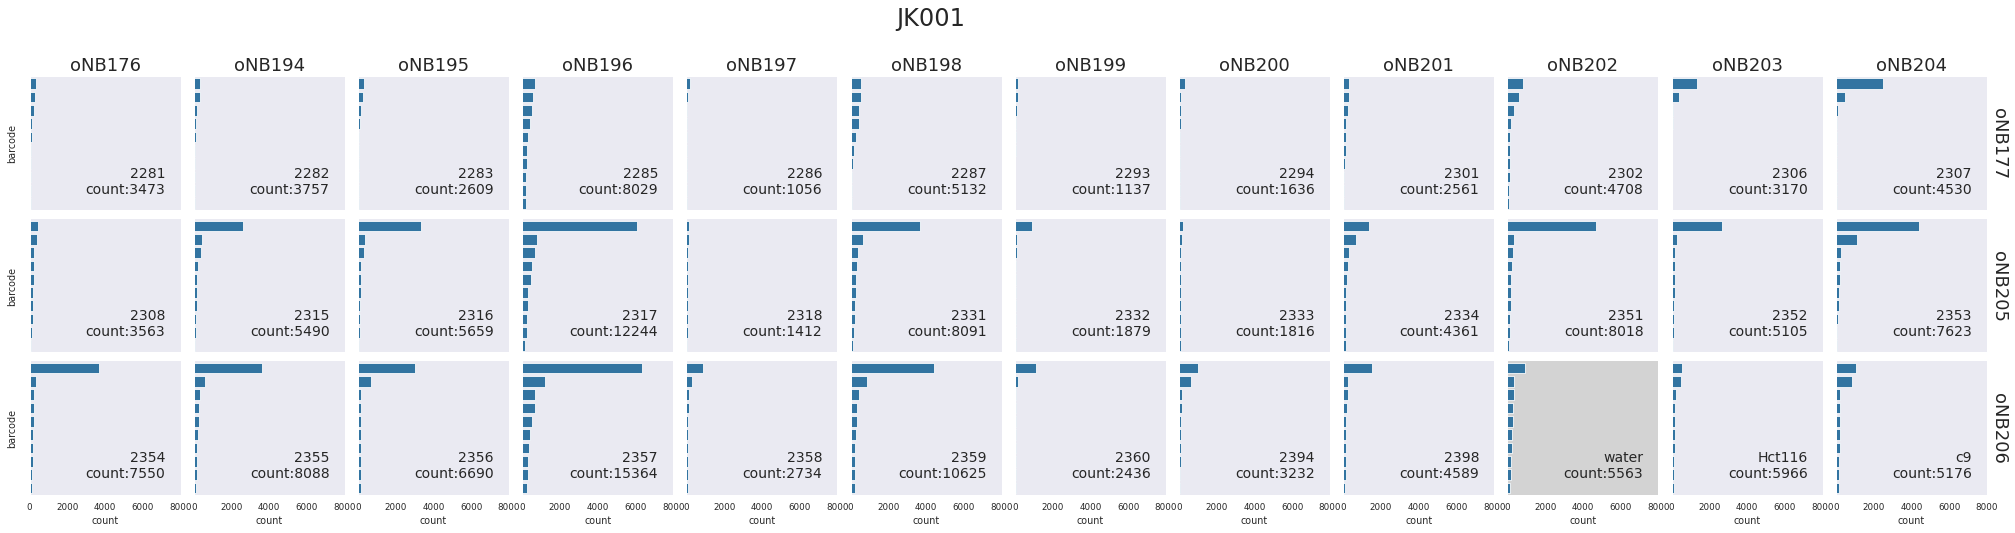

In [ ]:
def annotate(data, **kws):
    f = data.iloc[0]['forward_primer']
    r = data.iloc[0]['reverse_primer']
    n = counts_by_primers[(counts_by_primers['forward_primer'] == f) & (counts_by_primers['reverse_primer'] == r)].iloc[0]['count']
    sample = sample_dict[f][r]
    ax = plt.gca()
    if sample == 'water':
        ax.set_facecolor('lightgrey')
        
    ax.text(.9, .1, f"{sample}\ncount:{n}", fontsize=14, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
hist_grid = sns.FacetGrid(top_10_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
hist_grid.map_dataframe(
    sns.barplot, 
    x="count", 
    y="barcode",
    # order=counts_table['count'].value_counts().iloc[:5].index,
    orient='h')
hist_grid.map_dataframe(annotate)
hist_grid.set_yticklabels(None)
hist_grid.set_xticklabels(None)
hist_grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.85)
hist_grid.fig.suptitle(experiment, fontsize=24)

In [ ]:
jpbio.util.export_figure(hist_grid, "histograms", data_directory, experiment)

In [ ]:
counts_table[ counts_table['count'] > water_count ]

,forward_primer,reverse_primer,sample,barcode,count
2801,oNB177,oNB203,2306,GAGTGTGACAGTCTGTGTGACTGT,1325
3157,oNB177,oNB204,2307,GTGACTGTGTGACTCAGTCTCTCA,2481
3535,oNB205,oNB194,2315,GACTCAGTGTGTCTGTCAGTCAGT,2618
3789,oNB205,oNB195,2316,GTCTCTGACAGTGTGTCTCTCTCT,3331
3911,oNB205,oNB196,2317,CTCACTGAGTGACACACACAGAGA,6085
4483,oNB205,oNB198,2331,GTGACTGTGTGACTCAGTCTCTCA,3669
4934,oNB205,oNB201,2334,GTGAGTGTGAGACTGTCAGAGAGA,1374
5051,oNB205,oNB202,2351,GACTGAGTGAGAGAGACTGTGTCT,4686
5471,oNB205,oNB203,2352,GTGACTGTGTGACTCAGTCTCTCA,2659
5606,oNB205,oNB204,2353,CTGACACACTGACAGAGTCAGAGA,4402


# Other Stuff - Do Not Run

The following cells are work in progress and have not been tested.  The goals are:
1. Find barcodes that appear in more than one sample, and determine which to filter out.
1. Look for an automated way to identify samples that have 1 or 2 dominant barcodes.

## Overlapping Barcodes

In [ ]:
fwd = "oVK025"
rev = "oVK038"
bc = counts_table[(counts_table['forward_primer']==fwd) & (counts_table['reverse_primer']==rev)].nlargest(1,"count")["barcode"].iloc[0]
bc

'GTGTGTGTGTGAGTGTGTGAGTGT'

In [ ]:
counts_table[counts_table['barcode'] == bc]

,forward_primer,reverse_primer,sample,barcode,count
130,oVK025,oVK026,1941,GTGTGTGTGTGAGTGTGTGAGTGT,70
278,oVK025,oVK038,1942,GTGTGTGTGTGAGTGTGTGAGTGT,2515
418,oVK025,oVK039,1943,GTGTGTGTGTGAGTGTGTGAGTGT,105
533,oVK025,oVK040,1944,GTGTGTGTGTGAGTGTGTGAGTGT,69
662,oVK025,oVK041,1945,GTGTGTGTGTGAGTGTGTGAGTGT,81
...,...,...,...,...,...
9601,oVK037,oVK041,2020,GTGTGTGTGTGAGTGTGTGAGTGT,3
9675,oVK037,oVK042,2021,GTGTGTGTGTGAGTGTGTGAGTGT,1
9817,oVK037,oVK043,Hct 116,GTGTGTGTGTGAGTGTGTGAGTGT,9
9958,oVK037,oVK045,,GTGTGTGTGTGAGTGTGTGAGTGT,6


In [ ]:
with open('sample_N_table.csv', 'w') as sample_N:
    print(sample_N_table, file=sample_N)

NameError: ignored

In [ ]:
counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)

,count
barcode,
CAGTGTGACTCTGTCAGTGAGAGA,96
GTCAGAGTCTGACTGTGTCAGAGA,96
GTGTGTGTGTCAGTGACTGACAGT,96
CTGACTGTCTCACTCTGAGAGAGA,96
GACTGTCTGTGACAGTCTCACACA,95
...,...
GAGACAGTCACTGAGTGACTGACAGT,1
GAGACAGTCACTGAGTGACAGACACACAGA,1
GAGACAGAGTGAGAGTGTCTGA,1


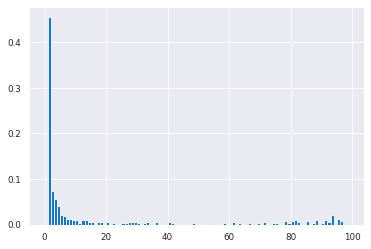

In [ ]:
counts_table.groupby(by='barcode').size().hist(bins=range(0,100), density=True)

In [ ]:
overlaps = counts_table.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .count() \
    .sort_values(by=['count'], ascending=False)
overlaps[(overlaps['count'] < 5) & (overlaps['count'] > 1)]

,count
barcode,
GTCAGTCTGTGAGAGTGTGAGAGT,4
GTGACACTGTCTGACAGTCAGTCT,4
GTGAGTGTCAGTCAGTCACACT,4
GACTGTGTCTCTGAGAGACACTGT,4
GAGACACTCAGTGACTCAGACTGT,4
...,...
GAGACTGTGTCTCTCTGTGTGTCA,2
CTGTCTGTCAGTGAGTGTGTGACT,2
GACAGACTCAGTCAGTCTGACTCT,2


In [ ]:
counts_and_overlaps = counts_table.set_index('barcode').join(overlaps, how='inner', lsuffix='_reads', rsuffix='_overlaps')
counts_and_overlaps

,forward_primer,reverse_primer,sample,count_reads,count_overlaps
barcode,,,,,
CACACACACTCACAGTCTCAGTGT,oVK025,oVK041,1945,1,9
CACACACACTCACAGTCTCAGTGT,oVK025,oVK043,1947,1,9
CACACACACTCACAGTCTCAGTGT,oVK032,oVK038,1966,1,9
CACACACACTCACAGTCTCAGTGT,oVK032,oVK039,1967,1,9
CACACACACTCACAGTCTCAGTGT,oVK035,oVK043,2024,1,9
...,...,...,...,...,...
GTGTGTGTGTGTGACACTCTCTCA,oVK035,oVK047,2029,1,4
GTGTGTGTGTGTGACACTCTCTCA,oVK036,oVK042,1999,1,4
GTGTGTGTGTGTGAGTCTCAGT,oVK036,oVK038,1995,2,1


In [ ]:
bc1 = counts_table['barcode'].iloc[0]
bc1

'GTGACACTGAGTCTGAGACAGTCT'

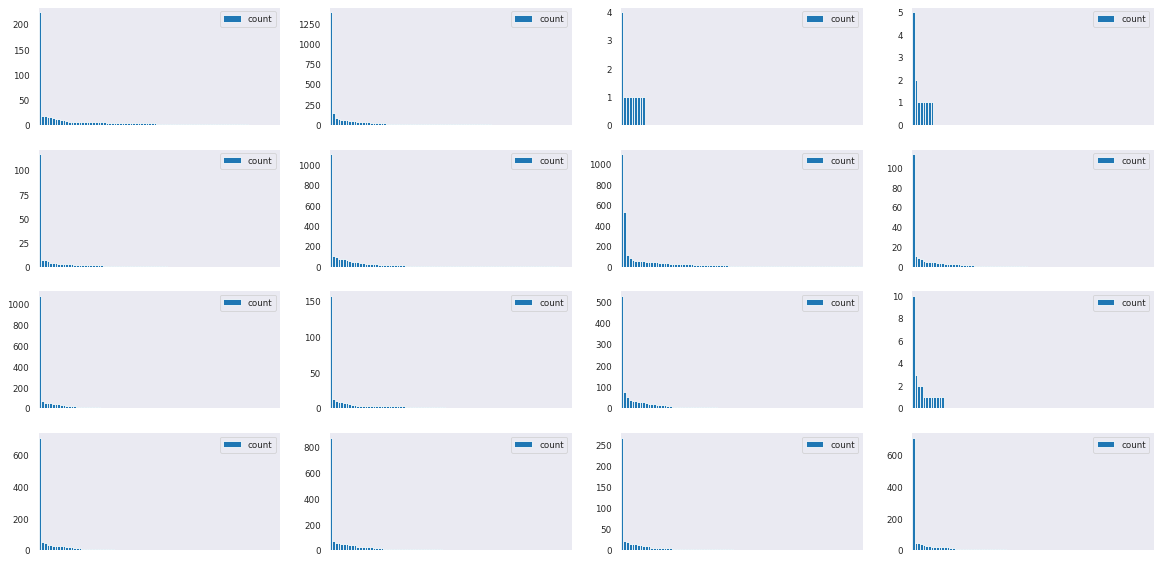

In [ ]:
h, w = (4,4)
barcode_list = list( counts_table['barcode'].sample(n=h*w) )
# print(barcode_list)
fig, axs = plt.subplots(h, w, figsize=(20,10), sharex=True)

for ax, bc in zip([ax for subaxs in axs for ax in subaxs], barcode_list):
    counts_table[counts_table['barcode'] == bc] \
        .sort_values(by='count', ascending=False) \
        .plot \
        .bar(
            ax=ax,
            xticks=[], 
            width=1
        )
plt.show()

In [ ]:
counts_table.groupby('barcode').head()

,forward_primer,reverse_primer,sample,barcode,count
99,oVK025,oVK026,1941,GTGACACTGAGTCTGAGACAGTCT,1108
70,oVK025,oVK026,1941,GAGAGAGAGTGTGAGAGACAGTGA,954
25,oVK025,oVK026,1941,CAGTGTGACTCTGTCAGTGAGAGA,90
113,oVK025,oVK026,1941,GTGTCTGACACTCAGTCTGAGAGT,89
130,oVK025,oVK026,1941,GTGTGTGTGTGAGTGTGTGAGTGT,70
...,...,...,...,...,...
10164,oVK037,oVK048,,GAGTGACTGTGACAGTCTCACACA,1
10172,oVK037,oVK048,,GAGTGTGTGTGACAGTGTGACTCA,1
10185,oVK037,oVK048,,GTCTGACTGAGACACTGTGACACA,1
10194,oVK037,oVK048,,GTGAGTGACTGAGACTGTGACTGT,1


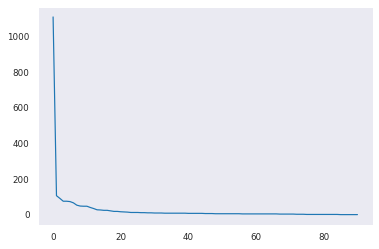

In [ ]:
counts_table[ counts_table['barcode'] == bc1 ]['count'] \
    .sort_values(ascending=False) \
    .reset_index() \
    .plot \
    .line(
        y='count',
        legend=False)

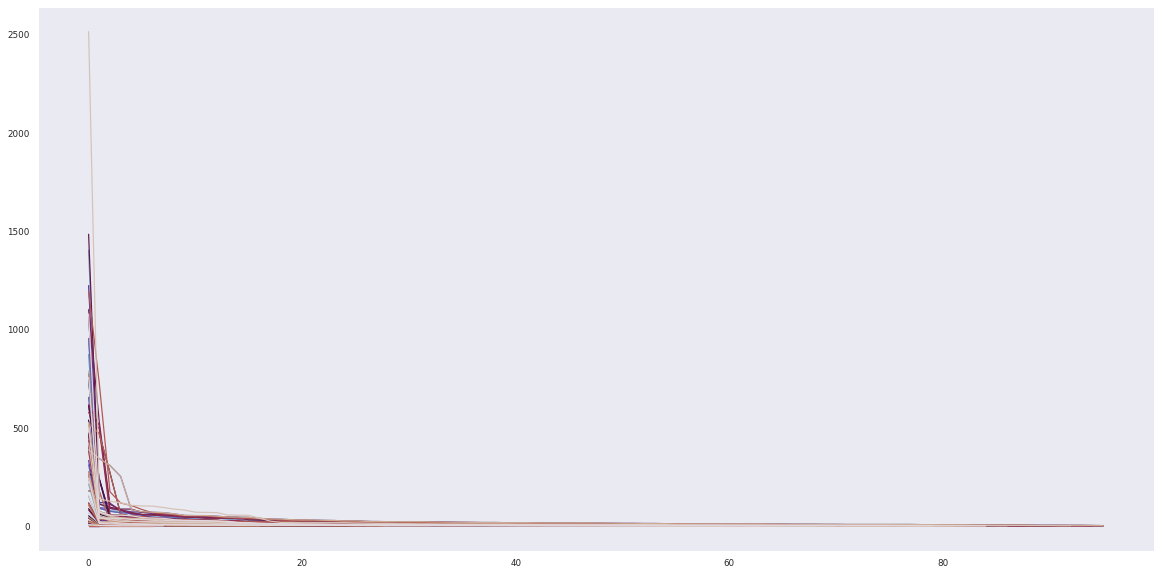

In [ ]:
N = 100

barcode_list = list( counts_table['barcode'].sample(n=N) )
fig, ax = plt.subplots(figsize=(20,10), sharex=True)

colors = plt.cm.twilight(np.linspace(0,1,N))
for bc, c in zip(barcode_list, colors):
    # print(f'barcode: {bc}\tcolor: {c}')
    counts_table[ counts_table['barcode'] == bc ]['count'] \
        .sort_values(ascending=False) \
        .reset_index() \
        .plot \
        .line(
            ax=ax,
            y='count',
            color=tuple(c),
            legend=False)

ValueError: ignored

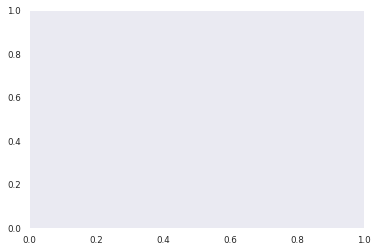

In [ ]:
# barcode_list = list( counts_table['barcode'].sample(n=10) )

fig, ax = plt.subplots()
for label, grp in counts_table.groupby('barcode').head():
    # print(grp)
    grp.sort_values(by='count', ascending=False).plot(ax=ax)
    # grp.plot(x = grp.index, y = 'count', ax = ax, label = label)

In [ ]:
counts_and_overlaps[counts_and_overlaps['count_overlap'] == 2]

KeyError: ignored

In [ ]:
counts_and_overlaps[counts_and_overlaps['sample'] == 'water'].sort_values(by='count_overlaps', ascending=False)

,forward_primer,reverse_primer,sample,count_reads,count_overlaps
barcode,,,,,
GTCAGAGTCTGACTGTGTCAGAGA,oVK033,oVK048,water,10,96
CTGACTGTCTCACTCTGAGAGAGA,oVK033,oVK048,water,13,96
CAGTGTGACTCTGTCAGTGAGAGA,oVK033,oVK048,water,18,96
GTGTGTGTGTCAGTGACTGACAGT,oVK033,oVK048,water,31,96
GAGTGAGTGTGAGACTGAGTCAGT,oVK033,oVK048,water,4,95
...,...,...,...,...,...
GAGTGTCAGTGTGAGTGAGAGTCT,oVK033,oVK048,water,1,8
CTGTCACACTCACAGTGAGACAGA,oVK033,oVK048,water,1,4
GACTCTGTGAGACTCAGTGACTGA,oVK033,oVK048,water,1,4


KeyError: ignored

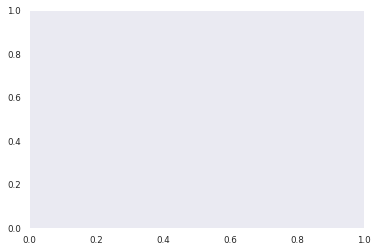

In [ ]:
counts_and_overlaps.drop(['forward_primer','reverse_primer','sample'],axis='columns') \
    .groupby(by='barcode') \
    .max() \
    .plot(x='count_overlap', y='count_reads', kind='scatter')

In [ ]:
# https://matplotlib.org/stable/gallery/specialty_plots/hinton_demo.html

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

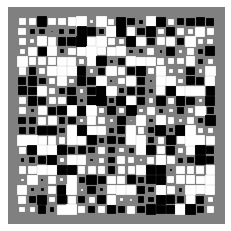

In [ ]:
np.random.seed(19680801)
hinton(np.random.rand(20, 20) - 0.5)
plt.show()

## Filter for Clones with 1 or 2 Dominant Barcodes

In [ ]:
z = y.reset_index()
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(z, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="running_percent",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)

for ax in g2.axes.flat:
    ax.axvline(x=0.5, color='r', linestyle='-')

plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

NameError: ignored

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
samples_list = [s for sublist in data for s in sublist if s != '']
samples_list

['1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 'water',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2022',
 '2023',
 '2024',
 '2025',
 '2027',
 '2028',
 '2029',
 '2030',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 'Hct 116']

In [ ]:
sample_N_table = {}

@interact
def pick_N_for_sample(sample=samples_list, barcode_count=[1,2,3,4,'many']):
    sample_N_table[sample] = barcode_count
    return counts_table[counts_table['sample']==sample].sort_values("count", ascending=False).head(25).plot.bar(
        y="count", 
        xticks=[], 
        figsize=(10,5), 
        linewidth=1,
        width=1)

interactive(children=(Dropdown(description='sample', options=('1941', '1942', '1943', '1944', '1945', '1946', …

In [ ]:
sample_N_table

{'1941': 1}